# Naive Bayes Classifier

This notebook implements a Naive Bayes classifier for image segmentation with support for:
- Grayscale images (1 channel)
- RGB images (3 channels)
- Multi-spectral images (36 channels)



## Import Required Libraries

In [1]:
import os
from random import shuffle, choice
from PIL import Image
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

## Configuration

Set up paths and mode of operation

In [2]:
mode = 1  # Choose between 1 (grayscale), 3 (RGB), or 36 (multi-spectral)
test_image = ""

# Define paths
rgb_images = "/home/bahy/Desktop/CMS/Deep Learning/Assignment 1/naive-classifier/Dataset/subset/3_images"
grayscale_images = "/home/bahy/Desktop/CMS/Deep Learning/Assignment 1/naive-classifier/Dataset/subset/1_images"
rgb_labels = grayscale_labels = "/home/bahy/Desktop/CMS/Deep Learning/Assignment 1/naive-classifier/Dataset/subset/labels"
multi_spectral_images = "/media/bahy/MEDO BAHY/CMS/Deep Learning/Assignment 1/naive-classifier/Dataset/subset/36_data/dataset.txt"
multi_spectral_labels = ""

# Create path mappings
image_paths = {
    1: grayscale_images,
    3: rgb_images,
    36: multi_spectral_images
}
images_directory = image_paths[mode]

label_paths = {
    1: grayscale_labels,
    3: rgb_labels,
    36: multi_spectral_labels
}
labels_directory = label_paths[mode]

## Data Processing Functions

Functions for loading and processing image data

In [3]:
def process_images(image_files):
    """
    given an array of names of image files, returns a 2D numpy array of pixels
    the array is of shape (n, m) where :
    - n is the total number of pixels in all images
    - m is the number of channels
    """
    all_pixels = []
    for image_file in image_files:
        path = os.path.join(images_directory, image_file)
        image = Image.open(path)
        image_array = np.array(image)
        if image_array.ndim == 2:  # Grayscale image
            image_array = image_array[:, :, np.newaxis]
        pixels = image_array.reshape(-1, image_array.shape[-1])
        all_pixels.append(pixels)
    return np.vstack(all_pixels)

def process_labels(label_files):
    """
    given an array of names of txt files containing either 0 or 255,
    returns a 1D numpy array of labels 
    """
    all_labels = []
    for label_file in label_files:
        path = os.path.join(labels_directory, label_file)
        with open(path, 'r') as file:
            labels = np.array([int(value) for line in file for value in line.split()])
            all_labels.append(labels)
    labels = np.hstack(all_labels).reshape(-1, 1)
    labels.flatten()
    labels = np.where(labels == 255, 1, labels)
    return labels

def text_to_datapoint(file_path):
    """
    Read numbers from a text file and convert them to arrays
    Args:
        file_path: Path to text file containing space-separated numbers
    Returns:
        List where each element is either a single integer or an array of integers
    """
    datapoints = []
    with open(file_path, 'r') as file:
        for line in file:
            # Split line into numbers and convert to int
            numbers = [int(x) for x in line.strip().split()]
            
            # If only one number in line, append the number
            # Otherwise append the array of numbers
            if len(numbers) == 1: # for the case of reading the labels file
                datapoints.append(numbers[0])
            else:
                datapoints.append(numbers)
    
    return np.array(datapoints)

def process_file(input_path):
    """
    Reads the dataset.txt file,
    makes the train-test split (80-20 per class),
    creates the x_train, y_train, x_test, and y_test files
    returns the paths of the created files
    """
    directory = os.path.dirname(input_path)
    
    # Create paths for output files
    x_train_path = os.path.join(directory, 'x_train.txt')
    y_train_path = os.path.join(directory, 'y_train.txt')
    x_test_path = os.path.join(directory, 'x_test.txt')
    y_test_path = os.path.join(directory, 'y_test.txt')
    
    # Store data by class
    class_data = defaultdict(list)
    line_count = 0
    
    # First pass: Read and organize data by class
    with open(input_path, 'r') as input_file:
        for line in input_file:
            line_count += 1
            numbers = line.strip().split()
            
            if len(numbers) != 37:
                print(f"Warning: Line {line_count} has {len(numbers)} numbers instead of 37")
                continue
            
            features = numbers[:-1]
            label = numbers[-1]
            class_data[label].append((features, label))
    
    # Initialize files
    with open(x_train_path, 'w') as x_train_file, \
         open(y_train_path, 'w') as y_train_file, \
         open(x_test_path, 'w') as x_test_file, \
         open(y_test_path, 'w') as y_test_file:
        
        # Process each class
        for label, data in class_data.items():
            # Shuffle data for this class
            shuffle(data)
            
            # Calculate split point (80%)
            split_point = int(len(data) * 0.8)
            
            # Train data (80%)
            for features, lbl in data[:split_point]:
                x_train_file.write(' '.join(features) + '\n')
                y_train_file.write(lbl + '\n')
            
            # Test data (20%)
            for features, lbl in data[split_point:]:
                x_test_file.write(' '.join(features) + '\n')
                y_test_file.write(lbl + '\n')
                
    return x_train_path, y_train_path, x_test_path, y_test_path

def train_test_split(images_directory, labels_directory, train_size = 0.8):
    global test_image
    """
    Reads the images and labels from the given directories,
    makes the train-test split ,
    saves a random test image to be used later for visualization,
    returns the x_train, y_train, x_test, and y_test arrays
    """
   # check if the image path is a directory
    if not os.path.isdir(images_directory):
        x_train, y_train, x_test, y_test = process_file(multi_spectral_images)
        return text_to_datapoint(x_train), text_to_datapoint(y_train), text_to_datapoint(x_test), text_to_datapoint(y_test)
    images = [f for f in os.listdir(images_directory) if os.path.isfile(os.path.join(images_directory, f))]
    labels = [f for f in os.listdir(labels_directory) if os.path.isfile(os.path.join(labels_directory, f))]
    images.sort()
    labels.sort()
    dataset = zip(images, labels)
    dataset = list(dataset)
    shuffle(dataset)
    images, labels = zip(*dataset)
    train_size = int(len(dataset) * train_size)
    x_train, y_train = images[:train_size], labels[:train_size]
    x_test, y_test = images[train_size:], labels[train_size:]
    test_image = choice(x_test)
    return process_images(x_train), process_labels(y_train), process_images(x_test), process_labels(y_test)

## Statistical Functions

Helper functions for statistical calculations

In [4]:
def count_values(array):
    # Count occurrences of each value
    max_value = max(array)
    counts = [0] * (max_value + 1)
    for value in array:
        counts[value] += 1
    return counts

def stats(values):
    """
    Calculate mean and standard deviation of values
    Args:
        values: Array of values (either scalars or 1D arrays)
    Returns:
        tuple: (mean, std)
    """
    # Calculate mean
    sum_values = 0
    n = len(values)
    for value in values:
        sum_values += value
    mean = sum_values / n
    
    # Calculate variance
    sum_squared_diff = 0
    for value in values:
        # Check if value is array or scalar
        diff = value - mean
        sum_squared_diff += diff * diff
    variance = sum_squared_diff / n
    
    # # Calculate standard deviation
    # std = (variance) ** 0.5
    
    return mean, variance

## Naive Bayes Model Implementation

In [5]:
def BM_multi_spectral(data, truth):
    """
    Multi-spectral version of BayesModel for 36-channel data with 6 classes
    Args:
        data: Array of arrays, each sub-array has length 36 (spectral channels)
        truth: Array of class labels (1-7, excluding 6)
    Returns:
        model: Dictionary containing class probabilities and channel statistics
    """
    model = {}
    
    # Count occurrences of each class
    truth = truth.flatten()
    unique_classes = np.unique(truth)
    class_counts = {cls: np.sum(truth == cls) for cls in unique_classes}
    total_samples = len(truth)
    
    # Calculate prior probabilities P(class)
    for cls in unique_classes:
        model[f"P({cls})"] = class_counts[cls] / total_samples
    
    # Initialize lists to store channel values for each class
    class_channels = {cls: [[] for _ in range(36)] for cls in unique_classes}
    
    # Separate data by class and channel
    for i in range(len(data)):
        sample_point = data[i]
        point_class = truth[i]
        
        # Store each channel value in corresponding class list
        for channel in range(36):
            class_channels[point_class][channel].append(sample_point[channel])
    
    # Calculate mean and variance for each channel in each class
    for cls in unique_classes:
        for channel in range(36):
            channel_values = class_channels[cls][channel]
            mean, variance = stats(channel_values)
            
            model[f"mean_{cls}_channel_{channel}"] = mean
            model[f"variance_{cls}_channel_{channel}"] = variance
    
    return model

def BayesModel(data, truth):
    """
    Naive Bayes model for grayscale or RGB data
    Args:

        data: Array of arrays, each sub-array has length 1 (grayscale) or 3 (RGB)
        truth: Array of class labels (0 or 255)
    Returns:
        model: Dictionary containing class probabilities and channel statistics
    """
    if (len(data[0]) == 36):
        # Multi-spectral image
        return BM_multi_spectral(data, truth)

    model = {}
    # count the number of zeros and 255s in the truth
    truth = truth.flatten()
    count = count_values(truth)
    zeros = count[0]
    # print ("Actual count of 0s: ", zeros)
    ones = count[1]
    # print ("Actual count of 255s: ", ones)
    model["P(0)"] = zeros / len(truth)
    model["P(1)"] = ones / len(truth)

    # Initialize lists for each class
    grayscale_0 = []
    grayscale_1 = []
    red_0 = []
    red_1 = []
    green_0 = []
    green_1 = []
    blue_0 = []
    blue_1 = []

    for i in range(len(data)):
        sample_point = data[i]
        point_class = truth[i]
        number_of_channels = len(sample_point)
        
        if number_of_channels == 1:
            if point_class == 0:
                grayscale_0.append(sample_point[0])
            else:
                grayscale_1.append(sample_point[0])
        elif number_of_channels == 3:
            if point_class == 0:
                red_0.append(sample_point[0])
                green_0.append(sample_point[1])
                blue_0.append(sample_point[2])
            else:
                red_1.append(sample_point[0])
                green_1.append(sample_point[1])
                blue_1.append(sample_point[2])

    if number_of_channels == 1:
        # Calculate statistics for each class in grayscale
        mean_0, var_0 = stats(grayscale_0)
        mean_1, var_1 = stats(grayscale_1)
        model["mean_0_grayscale"] = mean_0
        model["variance_0_grayscale"] = var_0
        model["mean_1_grayscale"] = mean_1
        model["variance_1_grayscale"] = var_1
    elif number_of_channels == 3:
        # Calculate statistics for each class in RGB
        red_mean_0, red_var_0 = stats(red_0)
        red_mean_1, red_var_1 = stats(red_1)
        model["mean_0_red"] = red_mean_0
        model["variance_0_red"] = red_var_0
        model["mean_1_red"] = red_mean_1
        model["variance_1_red"] = red_var_1

        green_mean_0, green_var_0 = stats(green_0)
        green_mean_1, green_var_1 = stats(green_1)
        model["mean_0_green"] = green_mean_0
        model["variance_0_green"] = green_var_0
        model["mean_1_green"] = green_mean_1
        model["variance_1_green"] = green_var_1

        blue_mean_0, blue_var_0 = stats(blue_0)
        blue_mean_1, blue_var_1 = stats(blue_1)
        model["mean_0_blue"] = blue_mean_0
        model["variance_0_blue"] = blue_var_0
        model["mean_1_blue"] = blue_mean_1
        model["variance_1_blue"] = blue_var_1

    return model

## Prediction Functions

In [6]:
def BP_multi_spectral(model, test_data):
    """
    Multi-spectral version of BayesPredict for 36-channel data with 6 classes
    Args:
        model: Dictionary containing class probabilities and channel statistics
        test_data: Array of arrays, each sub-array has length 36 (spectral channels)
    Returns:
        lbl: List of predicted class labels
    """
    lbl = []
    for sample in test_data:
        class_scores = {}
        
        # Calculate score for each class (1-7, excluding 6)
        for cls in range(1, 8):
            if cls == 6:  # Skip class 6
                continue
            
            # Start with log of prior probability
            score = np.log(model[f"P({cls})"])
            
            # Add log-likelihood for each channel
            for channel in range(36):
                mean = model[f"mean_{cls}_channel_{channel}"]
                variance = model[f"variance_{cls}_channel_{channel}"]
                
                # Calculate gaussian probability
                p_channel = (1 / ((2 * np.pi * variance) ** 0.5)) * \
                          np.exp(-((sample[channel] - mean) ** 2) / (2 * variance))
                
                # Add log probability
                if p_channel > 0:
                    score += np.log(p_channel)
                else:
                    score = float('-inf')  # Handle zero probabilities
            
            class_scores[cls] = score
        
        # Choose class with highest score
        predicted_class = max(class_scores.items(), key=lambda x: x[1])[0]
        lbl.append(predicted_class)
    
    return lbl

def BayesPredict(model, test_data):
    """
    BayesPredict for grayscale or RGB data
    Args:
        model: Dictionary containing class probabilities and channel statistics
        test_data: Array of arrays, each sub-array has length 1 (grayscale) or 3 (RGB)
    Returns:
        lbl: List of predicted class labels
    """
    lbl = []
    if (len(test_data[0]) == 36):   
        return BP_multi_spectral(model, test_data)
    for sample in test_data:
        if sample.shape[0] == 1:
            # Calculate for class 0
            p_gray_given_0 = (1 / ((2 * np.pi * model["variance_0_grayscale"]) ** 0.5)) * np.exp(-((sample[0] - model["mean_0_grayscale"]) ** 2) / (2 * model["variance_0_grayscale"]))
            log_p_gray_given_0 = np.log(p_gray_given_0)
            class_0_prediction = log_p_gray_given_0 + np.log(model["P(0)"])
            
            # Calculate for class 1
            p_gray_given_1 = (1 / ((2 * np.pi * model["variance_1_grayscale"]) ** 0.5)) * np.exp(-((sample[0] - model["mean_1_grayscale"]) ** 2) / (2 * model["variance_1_grayscale"]))
            log_p_gray_given_1 = np.log(p_gray_given_1)
            class_1_prediction = log_p_gray_given_1 + np.log(model["P(1)"])
            
            lbl.append(0 if class_0_prediction > class_1_prediction else 1)
        elif sample.shape[0] == 3:
            # Calculate for class 0
            p_red_given_0 = (1 / ((2 * np.pi * model["variance_0_red"]) ** 0.5)) * np.exp(-((sample[0] - model["mean_0_red"]) ** 2) / (2 * model["variance_0_red"]))
            p_green_given_0 = (1 / ((2 * np.pi * model["variance_0_green"]) ** 0.5)) * np.exp(-((sample[1] - model["mean_0_green"]) ** 2) / (2 * model["variance_0_green"]))
            p_blue_given_0 = (1 / ((2 * np.pi * model["variance_0_blue"]) ** 0.5)) * np.exp(-((sample[2] - model["mean_0_blue"]) ** 2) / (2 * model["variance_0_blue"]))
            
            log_p_red_given_0 = np.log(p_red_given_0)
            log_p_green_given_0 = np.log(p_green_given_0)
            log_p_blue_given_0 = np.log(p_blue_given_0)
            
            class_0_prediction = log_p_red_given_0 + log_p_green_given_0 + log_p_blue_given_0 + np.log(model["P(0)"])
            
            # Calculate for class 1
            p_red_given_1 = (1 / ((2 * np.pi * model["variance_1_red"]) ** 0.5)) * np.exp(-((sample[0] - model["mean_1_red"]) ** 2) / (2 * model["variance_1_red"]))
            p_green_given_1 = (1 / ((2 * np.pi * model["variance_1_green"]) ** 0.5)) * np.exp(-((sample[1] - model["mean_1_green"]) ** 2) / (2 * model["variance_1_green"]))
            p_blue_given_1 = (1 / ((2 * np.pi * model["variance_1_blue"]) ** 0.5)) * np.exp(-((sample[2] - model["mean_1_blue"]) ** 2) / (2 * model["variance_1_blue"]))
            
            log_p_red_given_1 = np.log(p_red_given_1)
            log_p_green_given_1 = np.log(p_green_given_1)
            log_p_blue_given_1 = np.log(p_blue_given_1)
            
            class_1_prediction = log_p_red_given_1 + log_p_green_given_1 + log_p_blue_given_1 + np.log(model["P(1)"])
            
            lbl.append(0 if class_0_prediction > class_1_prediction else 1)
    return lbl

## Visualization Functions

In [7]:
def viz_multi_spectral(actual, predicted):
    # First 1260 elements for visualization (35x36)
    # vis_actual = actual[:1260].reshape(35, 36)
    # vis_predicted = predicted[:1260].reshape(35, 36)
    actual = np.array(actual[:1260])
    predicted = np.array(predicted[:1260])
    vis_actual = actual.reshape(35, 36)
    vis_predicted = predicted.reshape(35, 36)
    
    # Create color map for classes (1-5,7)
    colors = {
        1: [1, 0, 0],     # Red
        2: [0, 1, 0],     # Green
        3: [0, 0, 1],     # Blue
        4: [1, 1, 0],     # Yellow
        5: [1, 0, 1],     # Magenta
        7: [0, 1, 1]      # Cyan
    }
    
    # Create RGB images for actual and predicted
    actual_img = np.zeros((35, 36, 3))
    predicted_img = np.zeros((35, 36, 3))
    
    # Fill images with colors based on class labels
    for i in range(35):
        for j in range(36):
            actual_img[i, j] = colors[vis_actual[i, j]]
            predicted_img[i, j] = colors[vis_predicted[i, j]]
    
    # Create visualization
    plt.figure(figsize=(12, 5))
    
    # Plot actual labels
    plt.subplot(121)
    plt.imshow(actual_img)
    plt.title('Actual Labels')
    plt.axis('off')
    
    # Plot predicted labels
    plt.subplot(122)
    plt.imshow(predicted_img)
    plt.title('Predicted Labels')
    plt.axis('off')
    
    # Add colorbar legend
    legend_elements = [plt.Rectangle((0,0),1,1, fc=colors[cls]) for cls in sorted(colors.keys())]
    plt.figlegend(legend_elements, [f'Class {cls}' for cls in sorted(colors.keys())],
                  loc='center right', bbox_to_anchor=(1.2, 0.5))
    
    plt.tight_layout()
    plt.show()

def is_grayscale(image_array):
    # If 2D array, it's grayscale
    if len(image_array.shape) == 2:
        return True
    # If 3D array with single channel, it's grayscale
    elif len(image_array.shape) == 3:
        return image_array.shape[2] == 1
    return False

def visualize(model):
    """
    Visualize the prediction of the model on the test image
    
    Args:
        model: Dictionary containing class probabilities and channel statistics

    Returns:
        None
    """
    if labels_directory == "": # multi-spectral case , already visualized
        return
    # Get original image and create ground truth
    original_image = Image.open(os.path.join(images_directory, test_image))
    original_array = np.array(original_image)
    is_gray_scale = is_grayscale(original_array)
    # Create ground truth image (threshold at 128)
    grayscale_image = original_image.convert('L')
    ground_truth = np.array(grayscale_image)
    ground_truth = np.where(ground_truth > 128, 255, 0)
    
    # Create prediction image
    height, width = original_array.shape[:2]
    prediction = np.zeros((height, width), dtype=np.uint8)
    
    # Process each pixel
    for i in range(height):
        for j in range(width):
            if len(original_array.shape) == 3:  # RGB image
                pixel = original_array[i, j]
                test_pixel = np.array([[pixel[0], pixel[1], pixel[2]]])
            else:  # Grayscale image
                pixel = original_array[i, j]
                test_pixel = np.array([[pixel]])
                
            pred = BayesPredict(model, test_pixel)
            prediction[i, j] = 255 if pred[0] == 1 else 0
    
    # Create figure with three subplots
    
# Create figure with three subplots with red background
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    fig.patch.set_facecolor('red')  # Set figure background to red
    
    # Plot original image
    if is_gray_scale:
        ax1.imshow(original_array, cmap='gray')
    else:
        ax1.imshow(original_array)
    ax1.set_title('Original Image', color='blue')  # Set title color to blue
    ax1.set_facecolor('red')  # Set subplot background to red
    ax1.axis('off')
    
    # Plot ground truth
    # if is_gray_scale:
    #     ax2.imshow(ground_truth, cmap='gray')
    # else:
        # ax2.imshow(ground_truth)
    ax2.imshow(ground_truth, cmap='gray')
    ax2.set_title('Ground Truth', color='blue')  # Set title color to blue
    ax2.set_facecolor('red')  # Set subplot background to red
    ax2.axis('off')
    
    # Plot prediction
    # if is_gray_scale:
    #     ax3.imshow(prediction, cmap='gray')
    # else:
        # ax3.imshow(prediction)
    ax3.imshow(prediction, cmap='gray')
    ax3.set_title('Prediction', color='blue')  # Set title color to blue
    ax3.set_facecolor('red')  # Set subplot background to red
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

## Confusion Matrix Functions

In [8]:
def ConfMtrx_multi_spectral(actual, predicted):
    """
    Multi-spectral version of confusion matrix for 6-class classification
    Args:
        actual: Array of actual class labels (1-7, excluding 6)
        predicted: Array of predicted class labels
    """
    # Get unique classes (should be 1-5,7)
    unique_classes = sorted(list(set(actual.flatten())))
    n_classes = len(unique_classes)
    
    # Initialize confusion matrix
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=int)
    
    # Create class mapping (e.g., {1:0, 2:1, 3:2, 4:3, 5:4, 7:5})
    class_to_index = {cls: idx for idx, cls in enumerate(unique_classes)}
    
    # Fill confusion matrix
    for i in range(len(actual)):
        true_class = actual[i]
        pred_class = predicted[i]
        true_idx = class_to_index[true_class]
        pred_idx = class_to_index[pred_class]
        confusion_matrix[true_idx][pred_idx] += 1
    
    # Print confusion matrix
    print("\nConfusion Matrix:")
    print("-" * (8 * n_classes + 3))
    
    # Print header
    print("|Actual\\Pred|", end="")
    for cls in unique_classes:
        print(f"   {cls:<4}|", end="")
    print()
    print("-" * (8 * n_classes + 3))
    
    # Print matrix rows
    for i, true_class in enumerate(unique_classes):
        print(f"|{true_class:^10}|", end="")
        for j in range(n_classes):
            print(f" {confusion_matrix[i][j]:<6}|", end="")
        print()
    print("-" * (8 * n_classes + 3))
    
    # Calculate metrics for each class
    print("\nPer-class Metrics:")
    for i, cls in enumerate(unique_classes):
        tp = confusion_matrix[i][i]
        fp = sum(confusion_matrix[:, i]) - tp
        fn = sum(confusion_matrix[i, :]) - tp
        tn = confusion_matrix.sum() - tp - fp - fn
        
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"\nClass {cls}:")
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1 Score:  {f1:.4f}")
    
    # Calculate overall accuracy
    overall_accuracy = np.trace(confusion_matrix) / confusion_matrix.sum()
    print(f"\nOverall Accuracy: {overall_accuracy:.4f}")
    viz_multi_spectral(actual, predicted)
    return confusion_matrix

def ConfMtrx(actual, predicted):
    """
    Confusion matrix for binary classification
    
    Args:
        actual: Array of actual class labels (0 or 255)
        predicted: Array of predicted class labels
        
    Returns:
        confusion_matrix: List of lists containing True Positives, False Positives, True Negatives, and False Negatives
    """
    # search for the number 2 in the actual 
    # if found then it is a multi-spectral image
    if 2 in actual:
        return ConfMtrx_multi_spectral(actual, predicted)
    # Initialize confusion matrix
    # [TN FP]
    # [FN TP]
    confusion_matrix = [[0, 0], 
                       [0, 0]]
    
    # Flatten actual array if it's 2D
    actual = actual.flatten()
    actual = np.where(actual == 255, 1, actual)
    
    # Fill confusion matrix
    for i in range(len(actual)):
        if actual[i] == 0 and predicted[i] == 0:
            confusion_matrix[0][0] += 1  # True Negative
        elif actual[i] == 0 and predicted[i] == 1:
            confusion_matrix[0][1] += 1  # False Positive
        elif actual[i] == 1 and predicted[i] == 0:
            confusion_matrix[1][0] += 1  # False Negative
        else:
            confusion_matrix[1][1] += 1  # True Positive
    
    # Calculate metrics
    tn, fp = confusion_matrix[0]
    fn, tp = confusion_matrix[1]
    
    # Avoid division by zero
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Print results
    print("\nConfusion Matrix:")
    print("-" * 21)
    print(f"|    TN: {tn:<8} FP: {fp:<8}|")
    print(f"|    FN: {fn:<8} TP: {tp:<8}|")
    print("-" * 21)
    print("\nMetrics:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1_score:.4f}")
    
    return confusion_matrix

## Results



### Grayscale


Confusion Matrix:
---------------------
|    TN: 4022907  FP: 28353   |
|    FN: 149404   TP: 1975376 |
---------------------

Metrics:
Accuracy:  0.9712
Precision: 0.9858
Recall:    0.9297
F1 Score:  0.9569


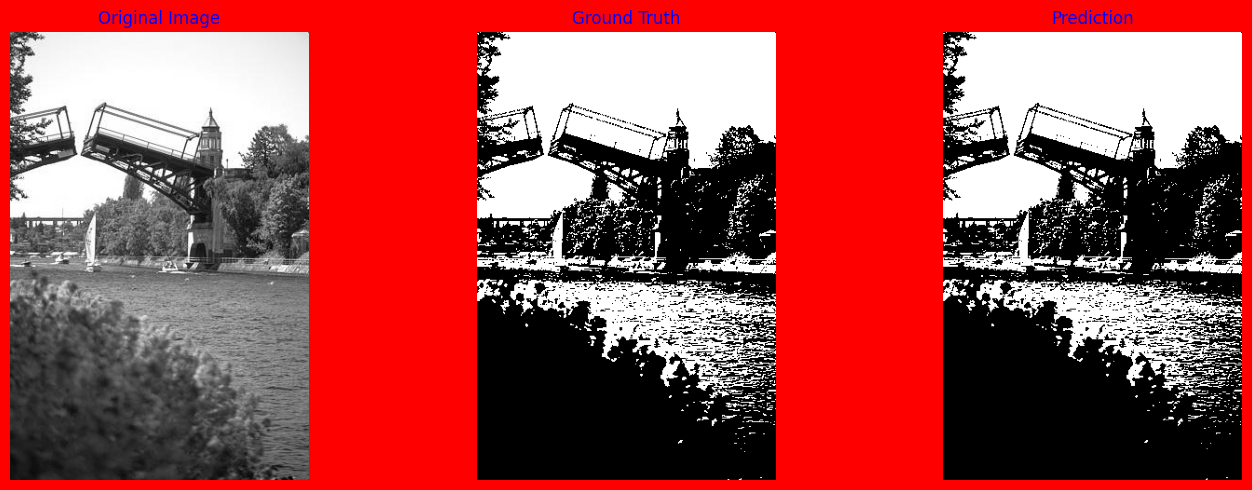

In [9]:
mode = 1
images_directory = image_paths[mode]
labels_directory = label_paths[mode]
x_train, y_train, x_test, y_test = train_test_split(images_directory, labels_directory)
BM = BayesModel(x_train, y_train)
lbl = BayesPredict(BM, x_test)
Mtrx = ConfMtrx(y_test, lbl)
visualize(BM)

### RGB


Confusion Matrix:
---------------------
|    TN: 4041782  FP: 173841  |
|    FN: 10395    TP: 1950022 |
---------------------

Metrics:
Accuracy:  0.9702
Precision: 0.9181
Recall:    0.9947
F1 Score:  0.9549


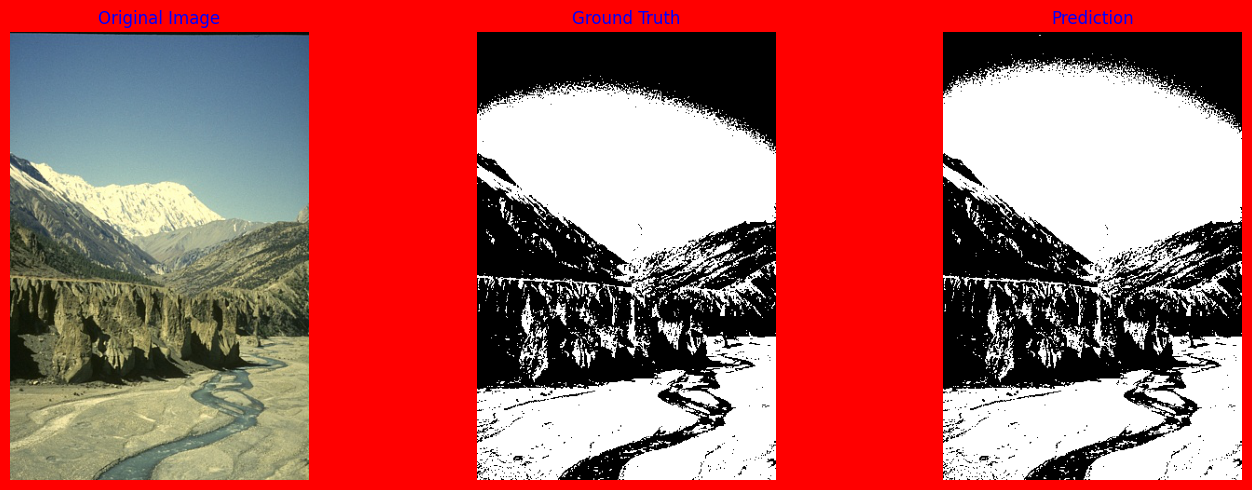

In [10]:
mode = 3 
images_directory = image_paths[mode]
labels_directory = label_paths[mode]
x_train, y_train, x_test, y_test = train_test_split(images_directory, labels_directory)
BM = BayesModel(x_train, y_train)
lbl = BayesPredict(BM, x_test)
Mtrx = ConfMtrx(y_test, lbl)
visualize(BM)

### Multi-Spectrum


Confusion Matrix:
---------------------------------------------------
|Actual\Pred|   1   |   2   |   3   |   4   |   5   |   7   |
---------------------------------------------------
|    1     | 250   | 1     | 7     | 0     | 49    | 0     |
|    2     | 6     | 128   | 0     | 0     | 7     | 0     |
|    3     | 6     | 0     | 239   | 26    | 1     | 0     |
|    4     | 4     | 0     | 14    | 87    | 4     | 17    |
|    5     | 17    | 1     | 0     | 9     | 100   | 15    |
|    7     | 2     | 0     | 2     | 73    | 9     | 216   |
---------------------------------------------------

Per-class Metrics:

Class 1:
Accuracy:  0.9287
Precision: 0.8772
Recall:    0.8143
F1 Score:  0.8446

Class 2:
Accuracy:  0.9884
Precision: 0.9846
Recall:    0.9078
F1 Score:  0.9446

Class 3:
Accuracy:  0.9566
Precision: 0.9122
Recall:    0.8787
F1 Score:  0.8951

Class 4:
Accuracy:  0.8860
Precision: 0.4462
Recall:    0.6905
F1 Score:  0.5421

Class 5:
Accuracy:  0.9132
Precision: 0.5882
Rec

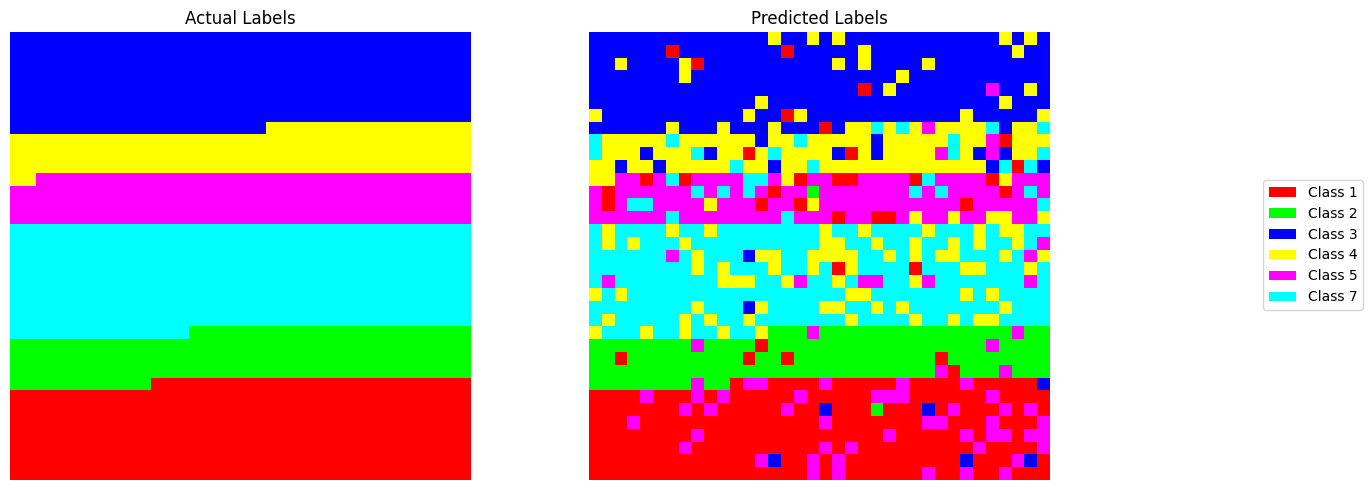

In [11]:
mode = 36
images_directory = image_paths[mode]
labels_directory = label_paths[mode]
x_train, y_train, x_test, y_test = train_test_split(images_directory, labels_directory)
BM = BayesModel(x_train, y_train)
lbl = BayesPredict(BM, x_test)
Mtrx = ConfMtrx(y_test, lbl)
visualize(BM)